# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [51]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers


In [52]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [53]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

batch_size = 128
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


In [54]:

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [55]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [56]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [57]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [58]:
#第三步編譯
''' 
SGD(隨機梯度下降) - Arguments
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.
RMSprop- Arguments
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
decay: float >= 0. Learning rate decay over each update.

Example:
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
'''

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, epsilon=None, decay=0.0)
rmsprop = optimizers.RMSprop(lr=0.001, epsilon=None, decay=0.0)
optimize = [sgd, adam, rmsprop]
models = []
name = ['adam', 'sgd', 'rmsprop']
history_models = []

for i in range(3):
     models.append(model)

# index = 0
for i in range(3):
    models[i].compile(optimizer = name[i], loss = 'categorical_crossentropy', metrics = ['accuracy'])


# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [59]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [60]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')

else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)


for i in range(len(models)):
    print('Training with optimizer %s', name[i])
    history_models.append(models[i].fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True))
    
'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
''' 


Using real-time data augmentation.

Training with optimizer %s adam
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 207s 4ms/step - loss: 1.7582 - acc: 0.3696 - val_loss: 1.3300 - val_acc: 0.5330
Epoch 2/20
50000/50000 [==============================] - 277s 6ms/step - loss: 1.2974 - acc: 0.5412 - val_loss: 1.0998 - val_acc: 0.6119
Epoch 3/20
50000/50000 [==============================] - 308s 6ms/step - loss: 1.1033 - acc: 0.6156 - val_loss: 0.9795 - val_acc: 0.6627
Epoch 4/20
50000/50000 [==============================] - 309s 6ms/step - loss: 0.9767 - acc: 0.6602 - val_loss: 0.9442 - val_acc: 0.6776
Epoch 5/20
50000/50000 [==============================] - 306s 6ms/step - loss: 0.8902 - acc: 0.6918 - val_loss: 0.8540 - val_acc: 0.7013
Epoch 6/20
50000/50000 [==============================] - 326s 7ms/step - loss: 0.8235 - acc: 0.7150 - val_loss: 0.9068 - val_acc: 0.6903
Epoch 7/20
50000/50000 [==============================

50000/50000 [==============================] - 187s 4ms/step - loss: 0.6930 - acc: 0.7815 - val_loss: 0.7313 - val_acc: 0.7691
Epoch 19/20
50000/50000 [==============================] - 215s 4ms/step - loss: 0.6888 - acc: 0.7814 - val_loss: 0.7201 - val_acc: 0.7820
Epoch 20/20
50000/50000 [==============================] - 191s 4ms/step - loss: 0.6973 - acc: 0.7816 - val_loss: 0.7205 - val_acc: 0.7893


In [63]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_names = []
model_paths = []
scores = []

for i in range(3):
    model_names.append(name[i]+'_'+model_name)
    model_paths.append(os.path.join(save_dir, model_names[i]))
    models[i].save(model_paths[i])
    print('Saved trained model at %s ' % model_paths[i])

    # Score trained model.
    scores.append(models[i].evaluate(x_test, y_test, verbose=1))
    print('Test loss:', scores[i][0])
    print('Test accuracy:', scores[i][1])

Saved trained model at D:\ML_100Days\Day076\saved_models\adam_keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 11s 1ms/step
Test loss: 0.7205209939002991
Test accuracy: 0.7893
Saved trained model at D:\ML_100Days\Day076\saved_models\sgd_keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 11s 1ms/step
Test loss: 0.7205209939002991
Test accuracy: 0.7893
Saved trained model at D:\ML_100Days\Day076\saved_models\rmsprop_keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 12s 1ms/step
Test loss: 0.7205209939002991
Test accuracy: 0.7893


In [64]:
#    第六步：輸出
import numpy 
scores = []
results = []

for i in range(3):
    print ( " test set " )
    scores.append(models[i].evaluate(x_test,y_test,batch_size=200,verbose= 0))
    print ( "" )
    print ( " The test loss is %f ", scores[i])
    results.append(models[i].predict(x_test,batch_size=200,verbose= 0))

#result_max = numpy.argmax(result, axis = 1 )
#test_max = numpy.argmax(y_test, axis = 1 )

#result_bool = numpy.equal(result_max, test_max)
#true_num = numpy.sum(result_bool)


 test set 

 The test loss is %f  [0.7205209875106812, 0.7893000018596649]
 test set 

 The test loss is %f  [0.7205209875106812, 0.7893000018596649]
 test set 

 The test loss is %f  [0.7205209875106812, 0.7893000018596649]


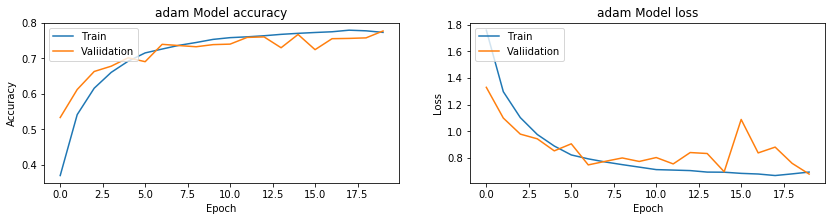

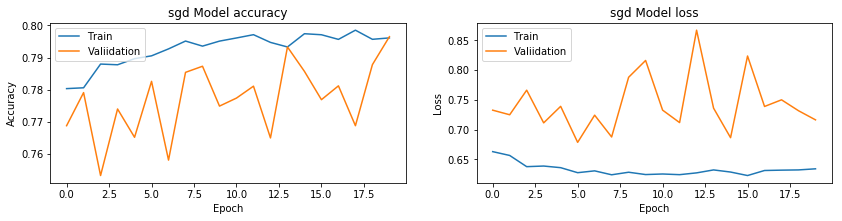

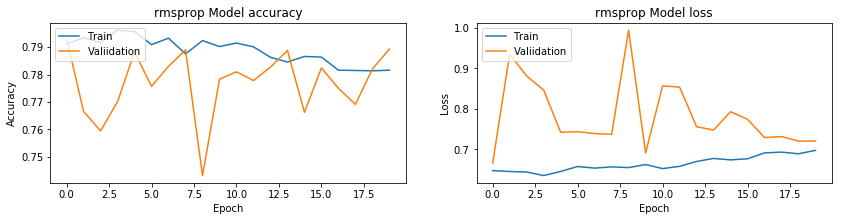

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline


# Plot training & validation accuracy values
for i in range(3):
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1+(2*i))
    plt.plot(history_models[i].history['acc'])
    plt.plot(history_models[i].history['val_acc'])
    title1 = name[i]+' Model accuracy'
    plt.title(title1)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(3, 2, 2+(2*i))
    plt.plot(history_models[i].history['loss'])
    plt.plot(history_models[i].history['val_loss'])
    title2 = name[i]+ ' Model loss'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()